# Evaluating the Movie Recommender System

This notebook tries to evaluate our recommender systems, simple recommender and content-based recommender, by comparing our recommendation to those of large corporations out there like Netflix, prime video, IMDb, etc. 

We'll start with the simple recommender and then move on to the content-based recommender.

## Simple Recommender 

A comparison with information listed on IMDb website  

1. Top-rated filter 
2. Genre-based filter (sort by rating descending) 

In [1]:
# import libraries 
from scipy.stats import wilcoxon
import pandas as pd
import numpy as np
from ast import literal_eval
from collections import Counter
from matplotlib import pyplot as plt

import warnings; warnings.simplefilter('ignore')

**TOP-rated filter**:
Build the TOP-RATED chart (step-by-step explanation is in Simple_recommender notebook)

In [2]:
md = pd.read_csv('data/movies_metadata.csv',low_memory=False)
md['genres_list'] = md['genres'].fillna('[]').apply(literal_eval).apply(lambda x: [i['name'] for i in x] if isinstance(x, list) else [])
md['year'] = pd.to_datetime(md['release_date'], errors='coerce').apply(lambda x: str(x).split('-')[0] if x != np.nan else np.nan)

m = md['vote_count'].quantile(0.95)
C = md['vote_average'].mean()
v = md['vote_count']
R = md['vote_average']

Mycolumns = ['title','original_language','year','runtime','genres_list','vote_count','vote_average'] 
dataframe=md[Mycolumns]
dataframe['weighted_rating'] = ((v/(v+m) * R) + (m/(m+v) * C))

TOP_rated = dataframe[(dataframe["vote_count"] >= m) & (dataframe['vote_count'].notnull()) & (dataframe['runtime'].notnull())]

TOP_rated['vote_count'] = TOP_rated['vote_count'].astype('int')
TOP_rated['runtime'] = TOP_rated['runtime'].astype('int')
TOP_rated['weighted_rating']=TOP_rated['weighted_rating'].round(decimals = 1)

In [3]:
our_top_10=TOP_rated.sort_values('weighted_rating', ascending=False).head(10)

In [4]:
our_top_10

,title,original_language,year,runtime,genres_list,vote_count,vote_average,weighted_rating
314,The Shawshank Redemption,en,1994,142,"[Drama, Crime]",8358,8.5,8.4
834,The Godfather,en,1972,175,"[Drama, Crime]",6024,8.5,8.3
12481,The Dark Knight,en,2008,152,"[Drama, Action, Crime, Thriller]",12269,8.3,8.2
292,Pulp Fiction,en,1994,154,"[Thriller, Crime]",8670,8.3,8.2
2843,Fight Club,en,1999,139,[Drama],9678,8.3,8.2
522,Schindler's List,en,1993,195,"[Drama, History, War]",4436,8.3,8.1
351,Forrest Gump,en,1994,142,"[Comedy, Drama, Romance]",8147,8.2,8.1
23673,Whiplash,en,2014,105,[Drama],4376,8.3,8.1
3030,The Green Mile,en,1999,189,"[Fantasy, Drama, Crime]",4166,8.2,8.0
289,Leon: The Professional,fr,1994,110,"[Thriller, Crime, Drama]",4293,8.2,8.0


We can then compare our top-10 rated movies with that listed in IMDb. The image below shows a screenshot of IMDb Top 250 movies as rated by regular IMDb voters.

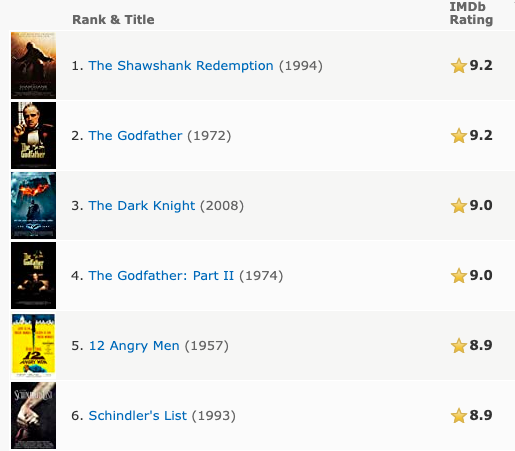

The complete list for the top 10 rated movies in IMDb:
1. The Shawshank Redemption (9.2)
2. The Godfather (9.2)
3. The Dark Knight (9.0)
4. The Godfather: PartII (9.0)
5. Angry Men (8.9)
6. Schindler's List (8.9)
7. The Lord of the Rings: The return of the king (8.9)
8. Pulp Fiction (8.9)
9. The Lord of the Rings: The Fellowship of the Ring (8.8)
10. Forrest Gump (8.8)

We can compare how many top-10 rated movies listed in IMDb are predicted by our recommender system.

In [5]:
our_top_10_title=our_top_10["title"]
IMDb_top_10_title=["The Shawshank Redemption",
             "The Godfather", 
             "The Dark Knight", 
             "The Godfather: PartII",
             "Angry Men",
             "Schindler's List",
             "The Lord of the Rings: The return of the king",
             "Pulp Fiction",
             "The Lord of the Rings: The Fellowship of the Ring",
             "Forrest Gump"]

In [6]:
# count how many top-10 rated movies listed in IMDb are predicted by our recommender system.
count=0
lst=[]

for i in our_top_10_title:
    if i in IMDb_top_10_title:
        count+=1
        lst.append(i)

print(count)
print (lst)

6
['The Shawshank Redemption', 'The Godfather', 'The Dark Knight', 'Pulp Fiction', "Schindler's List", 'Forrest Gump']


In [7]:
# find movies in the dataset 

search_title="Angry Men"

for i in TOP_rated["title"]:
    if i == search_title:
        print ("Found it")

**Findings**: 

1. Our IMDb score is lower than it appears on the IMDb website, probably because vote counts fluctuate but our dataset is fixed at a particular value.

2. If we use the list in the IMDb website be our gold standard, then our TOP_rated filter predicts 6/10 of the movies listed in IMDb, and has an accuracy of 60%. 

3. Some movies are not included in our dataset, e.g "Angry Men", so we can't interpret its ranking with our filter. 

**Genre-based filter**: Build the genre chart (step-by-step explanation is in Simple_recommender notebook)

In [8]:
s = md.apply(lambda x: pd.Series(x['genres_list']),axis=1).stack().reset_index(level=1, drop=True)
s.name = 'genre'
gen_md = md.drop('genres_list', axis=1).join(s)

def build_genre_chart(genre, percentile):
    df = gen_md[gen_md['genre'] == genre]
    C = df['vote_average'].mean()
    m = df['vote_count'].quantile(percentile)
    
    qualified = df[(df['vote_count'] >= m) & (df['vote_count'].notnull())][['title','original_language', 'year', 'runtime', 'vote_count', 'vote_average']]
    qualified['vote_count'] = qualified['vote_count'].astype('int')
    qualified['runtime'] = qualified['runtime'].astype('int')
    
    qualified['IMDB_rating'] = qualified.apply(lambda x: (x['vote_count']/(x['vote_count']+m) * x['vote_average']) + (m/(m+x['vote_count']) * C), axis=1)
    qualified['IMDB_rating']=qualified['IMDB_rating'].round(decimals = 1)
    qualified = qualified.sort_values('IMDB_rating', ascending=False).head(250)
    
    return qualified

In [9]:
build_genre_chart('Animation',0.85).head(10)

,title,original_language,year,runtime,vote_count,vote_average,IMDB_rating
5481,Spirited Away,ja,2001,125,3968,8.3,8.2
40251,Your Name.,ja,2016,106,1030,8.5,8.1
9698,Howl's Moving Castle,ja,2004,119,2049,8.2,8.0
2884,Princess Mononoke,ja,1997,134,2041,8.2,8.0
359,The Lion King,en,1994,89,5520,8.0,7.9
5553,Grave of the Fireflies,ja,1988,89,974,8.2,7.8
5833,My Neighbor Totoro,ja,1988,86,1730,8.0,7.8
30315,Inside Out,en,2015,94,6737,7.9,7.8
24455,Big Hero 6,en,2014,102,6289,7.8,7.7
13724,Up,en,2009,96,7048,7.8,7.7


The list below are top 10 rated "animation" movies in IMDb website

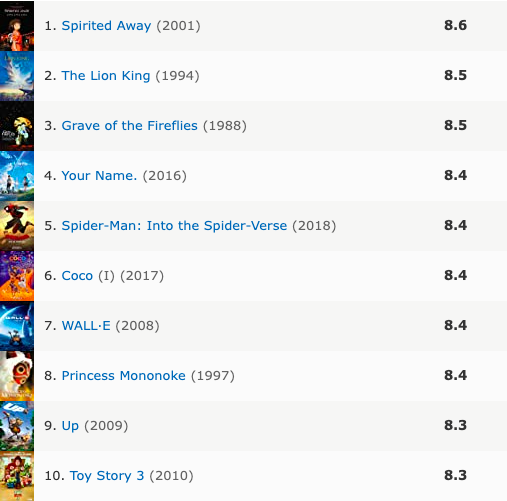

Our filter is also 60% accurate, with six out of ten movies showing in both our recommendations and on the IMDb website.

**Remarks:**
1. Similiar approaches can be used to evaluate our popularity, runtime, and year filter by comparing with the list in the IMDb website. However, the website only consider one feature at a time, so it couldn't produce a more comprehensive chart like we did for our recommender. 

2. In addition, to better serve the consumers, our simple recommender includes additional features such as directors and casts, and they are normally excluded in mainstream filters.

## Content-based Recommender 

A comparison with mainstream movie websites.  

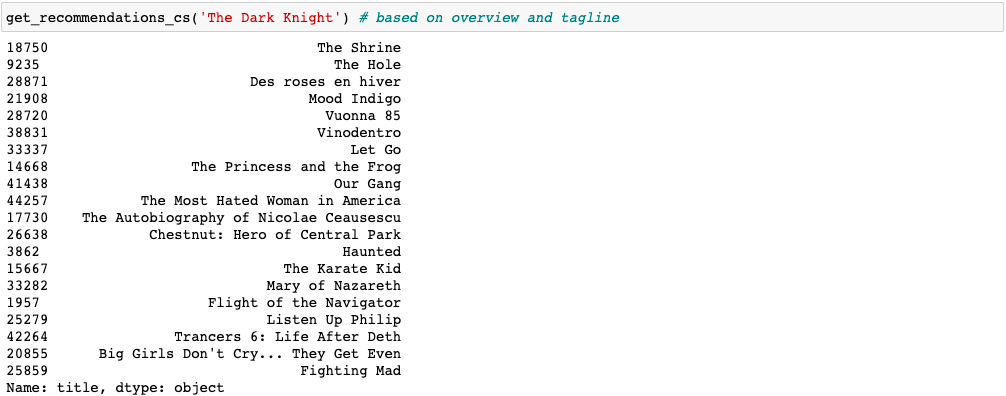

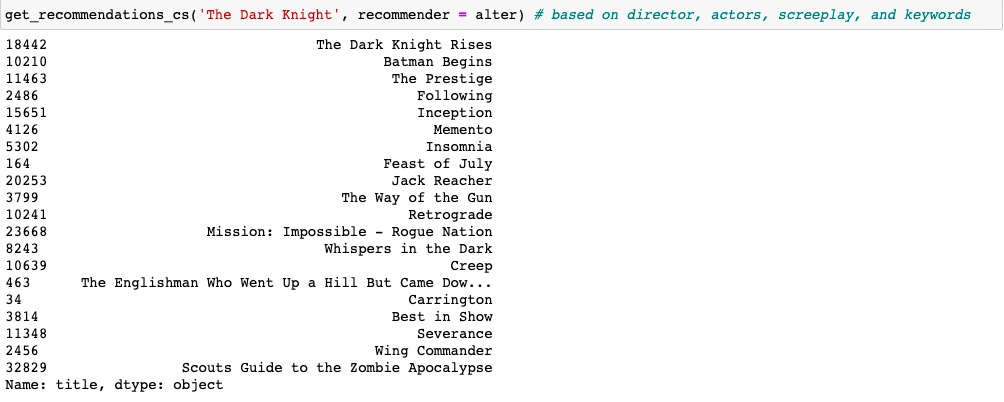

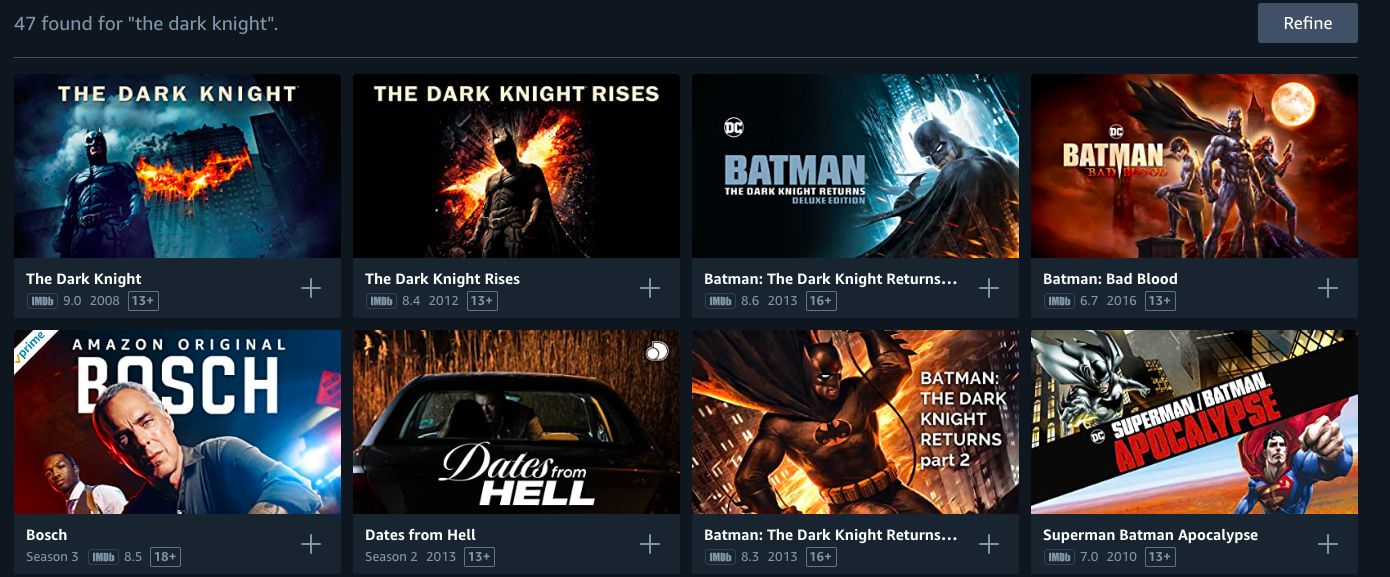